In [1]:
import numpy as np

import matplotlib.pyplot as plt

from LIMxCMBL.cross_spectrum import *
from LIMxCMBL.init import *
from LIMxCMBL.noise import *
from LIMxCMBL.kernels import *

from scipy.signal.windows import dpss

from tqdm import tqdm

# CCAT-prime
zmin = 3.5
zmax = 8.1
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

_chimin, _chimax = chis_resample[window][0], chis_resample[window][-1]


Lambdas = np.logspace(-5, 0, 50)
Lambda = Lambdas[21]
print(Lambda)



chis_resample_len = int(np.log2(len(chis_resample)))
print(chis_resample_len)
oup_fname = '/scratch/users/delon/LIMxCMBL/eHIeHI/zmin_%.5f_zmax_%.5f_Lambda_%.5e_chi_sample_2e%d'%(zmin, zmax, Lambda,chis_resample_len)
eIeI = np.load(oup_fname + 'eIeI.npy')
eIeLO = np.load(oup_fname + 'eIeLO.npy' ,)
eLOeI = np.load(oup_fname + 'eLOeI.npy' , )
eLOeLO = np.load(oup_fname + 'eLOeLO.npy', )
eHIeHI = eIeI + eLOeLO - eIeLO - eLOeI

IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]
IHi_kappa_windowed = IHi_kappa[:, window].astype(np.float64)

0.0013894954943731374
13


In [2]:
chis_restricted = chis_resample[np.where((chis_resample >= chimin) & (chis_resample <= chimax))]

In [3]:
chis_restricted.shape

(1652,)

In [4]:
eHIeHI.shape

(1652, 1652)

In [5]:
from sympy.parsing.mathematica import parse_mathematica

In [6]:
eLOeLO_diag_mathematica = None
with open('008.008.eLOeLO_diag_mathematica.txt', 'r') as f:
    eLOeLO_diag_mathematica = f.read()
eLOeLO_diag_mathematica = eLOeLO_diag_mathematica.replace('\[Pi]', 'Pi')

In [7]:
eLOeLO_diag_sympy = parse_mathematica(eLOeLO_diag_mathematica)

In [8]:
eLOeLO_diag_sympy

(-2*L*a**2*b**2*x*sin(2*L*x)*Ci(-2*L*x) + 2*L*a**2*b**2*x*sin(2*L*x)*Ci(2*L*x) + 2*I*pi*L*a**2*b**2*x*sin(2*L*x) - 2*L*a**2*b**2*x*cos(2*L*x)*Si(2*L*a) + 2*L*a**2*b**2*x*cos(2*L*x)*Si(2*L*b) - 2*L*a**2*b**2*x*Si(2*L*(a - x)) + 2*L*a**2*b**2*x*Si(2*L*(b - x)) + 2*L*a**2*b*x**2*sin(2*L*x)*Ci(-2*L*x) - 2*L*a**2*b*x**2*sin(2*L*x)*Ci(2*L*x) - 2*I*pi*L*a**2*b*x**2*sin(2*L*x) + 2*L*a**2*b*x**2*cos(2*L*x)*Si(2*L*a) - 2*L*a**2*b*x**2*cos(2*L*x)*Si(2*L*b) + 2*L*a**2*b*x**2*Si(2*L*(a - x)) + 2*L*a**2*b*x**2*Si(2*L*(-b + x)) + 2*L*a*b**2*x**2*sin(2*L*x)*Ci(-2*L*x) - 2*L*a*b**2*x**2*sin(2*L*x)*Ci(2*L*x) - 2*I*pi*L*a*b**2*x**2*sin(2*L*x) + 2*L*a*b**2*x**2*cos(2*L*x)*Si(2*L*a) - 2*L*a*b**2*x**2*cos(2*L*x)*Si(2*L*b) + 2*L*a*b**2*x**2*Si(2*L*(a - x)) - 2*L*a*b**2*x**2*Si(2*L*(b - x)) - 2*L*a*b*x**3*sin(2*L*x)*Ci(-2*L*x) + 2*L*a*b*x**3*sin(2*L*x)*Ci(2*L*x) + 2*I*pi*L*a*b*x**3*sin(2*L*x) - 2*L*a*b*x**3*cos(2*L*x)*Si(2*L*a) + 2*L*a*b*x**3*cos(2*L*x)*Si(2*L*b) - 2*L*a*b*x**3*Si(2*L*(a - x)) + 2*L*a*b*x**3*

In [9]:
eLOeLO_diag_sympy.free_symbols

{L, a, b, x}

In [10]:
from scipy import special

# I am passing as complex128 so that scipy uses the algorithm based on mpmath instead of Cephes
def SinIntegral(x):
    si, _ = special.sici(x.astype(np.complex128))
    return si

def CosIntegral(x):
    _, ci = special.sici(x.astype(np.complex128))
    return ci


modules = [
    {
        'Ci': CosIntegral,
        'Si': SinIntegral,
        'Cos': np.cos,
        'Sin': np.sin,
        'Log': np.log,
        'I': 1j,
    },
    'numpy'
]

In [11]:
from sympy import lambdify

eLOeLO_diag_numpy = lambdify(list(eLOeLO_diag_sympy.free_symbols), 
                             eLOeLO_diag_sympy, modules=modules)
eLOeLO_diag_numpy(a = chimin, b = chimax, x = (chimin + chimax) / 2, L = Lambda)

(5.271100388956778e-12-3.995833305544004e-12j)

In [12]:
eLOeLO.shape

(1652, 1652)

In [13]:
chis_restricted.shape

(1652,)

In [14]:
analytical_diag = np.real(eLOeLO_diag_numpy(a = chimin, b = chimax, x = chis_restricted, L = Lambda))

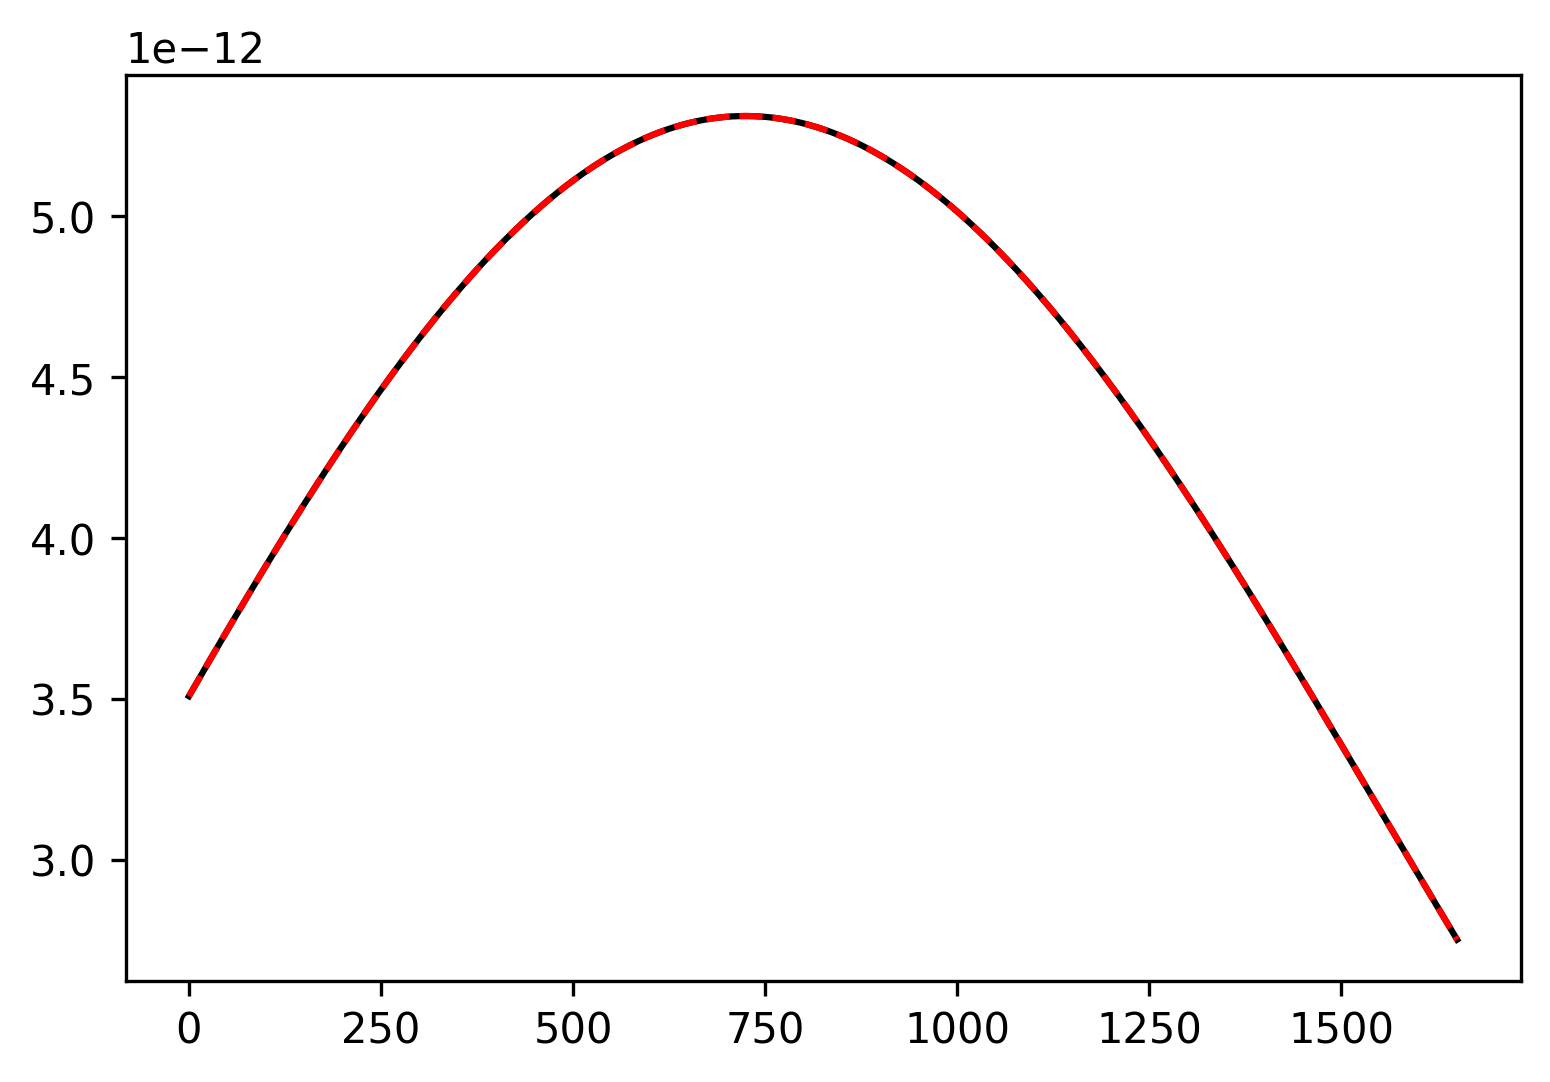

In [15]:
plt.figure(dpi = 300)
plt.plot(analytical_diag, 'k')
plt.plot(np.diag(eLOeLO), 'r--')

(-0.01, 0.01)

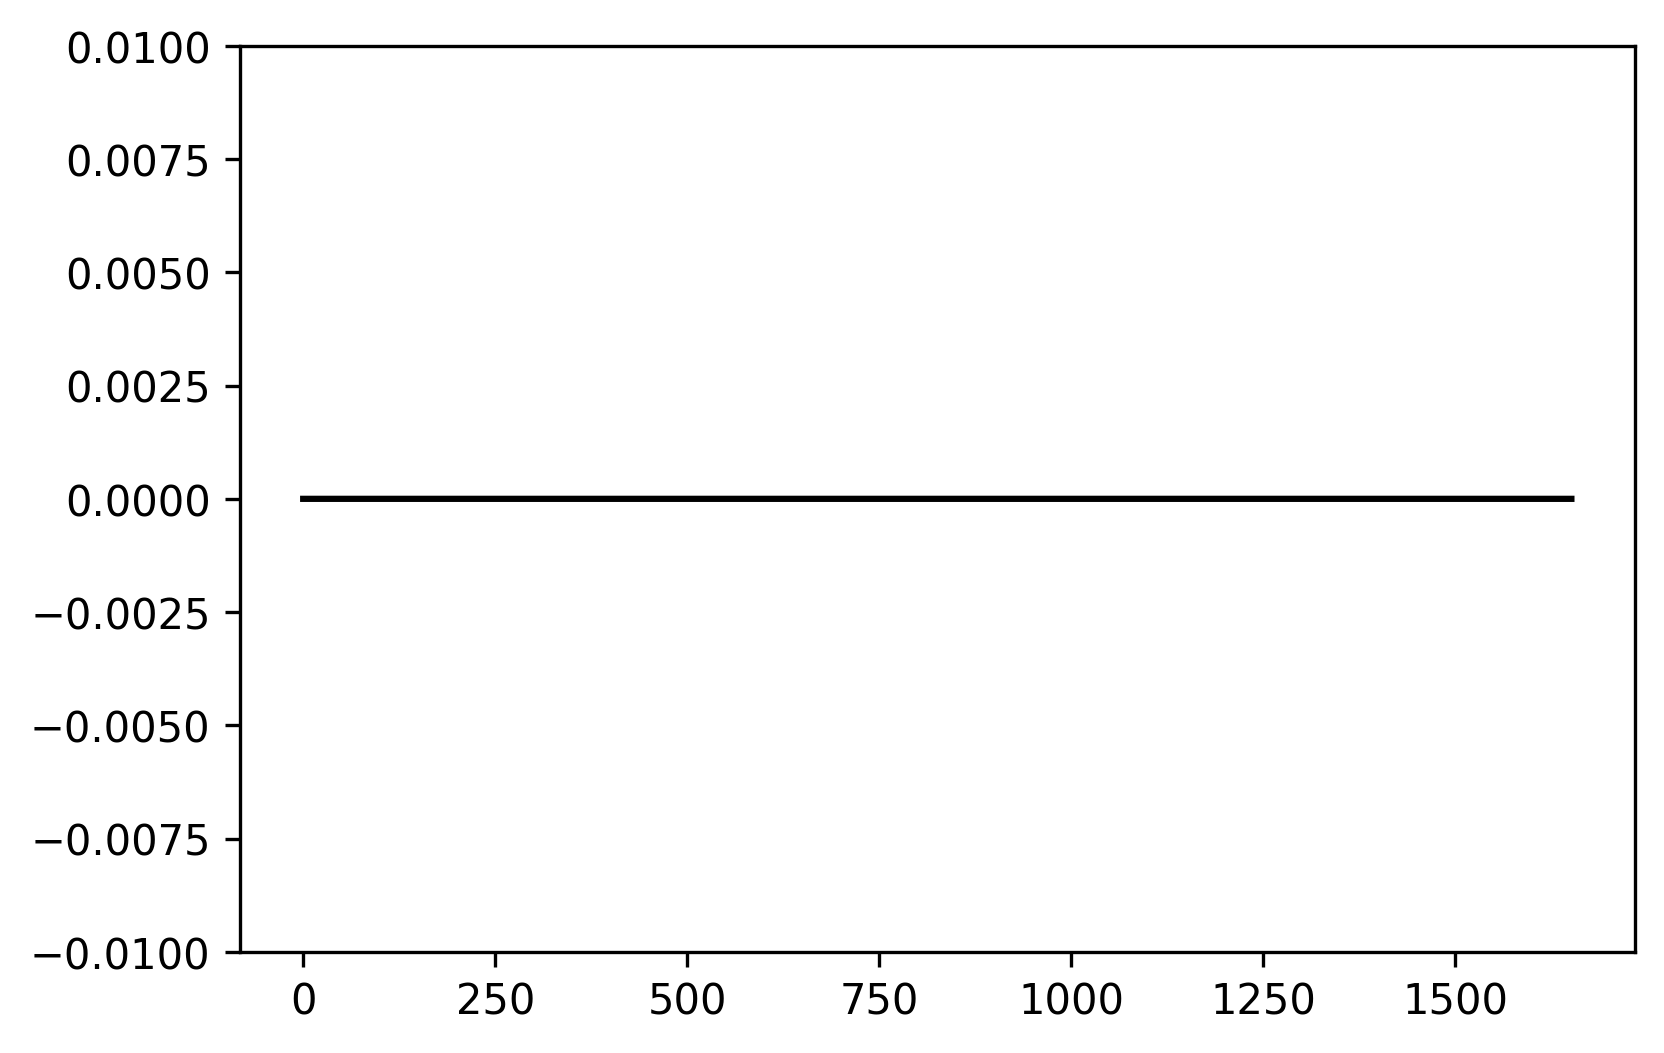

In [18]:
plt.figure(dpi = 300)
plt.plot((analytical_diag-np.diag(eLOeLO))/analytical_diag, 'k')
plt.ylim(-0.01, 0.01)

In [19]:
eLOeLO_off_diag_mathematica = None
with open('008.008.eLOeLO_off_diag_mathematica.txt', 'r') as f:
    eLOeLO_off_diag_mathematica = f.read()
eLOeLO_off_diag_mathematica = eLOeLO_off_diag_mathematica.replace('\[Pi]', 'Pi')

In [21]:
eLOeLO_off_diag_sympy = parse_mathematica(eLOeLO_off_diag_mathematica)

In [23]:
eLOeLO_off_diag_sympy

-(2*L*a*b*x**2*xp*cos(L*(x + xp))*Si(2*L*a) - 2*L*a*b*x**2*xp*cos(L*(x + xp))*Si(2*L*b) - 2*L*a*b*x*xp**2*cos(L*(x + xp))*Si(2*L*a) + 2*L*a*b*x*xp**2*cos(L*(x + xp))*Si(2*L*b) + a*b*x**2*log(a)*cos(L*(x - xp)) - a*b*x**2*log(b)*cos(L*(x - xp)) - a*b*x**2*log(-a + xp)*cos(L*(x - xp)) + a*b*x**2*log(b - xp)*cos(L*(x - xp)) + a*b*x**2*sin(L*(x - xp))*Si(2*L*(a - xp)) - a*b*x**2*sin(L*(x - xp))*Si(2*L*(b - xp)) - a*b*x**2*sin(L*(x + xp))*Si(2*L*a) + a*b*x**2*sin(L*(x + xp))*Si(2*L*b) + a*b*x**2*cos(L*(x - xp))*Ci(2*L*(a - xp)) - a*b*x**2*cos(L*(x - xp))*Ci(2*L*(b - xp)) - I*pi*a*b*x**2*cos(L*(x - xp)) - a*b*xp**2*log(a)*cos(L*(x - xp)) + a*b*xp**2*log(b)*cos(L*(x - xp)) + a*b*xp**2*log(-a + x)*cos(L*(x - xp)) - a*b*xp**2*log(b - x)*cos(L*(x - xp)) + a*b*xp**2*sin(L*(x - xp))*Si(2*L*(a - x)) + a*b*xp**2*sin(L*(x - xp))*Si(2*L*(-b + x)) + a*b*xp**2*sin(L*(x + xp))*Si(2*L*a) - a*b*xp**2*sin(L*(x + xp))*Si(2*L*b) - a*b*xp**2*cos(L*(x - xp))*Ci(2*L*(a - x)) + a*b*xp**2*cos(L*(x - xp))*Ci(2*L*(b

In [22]:
eLOeLO_off_diag_sympy.free_symbols

{L, a, b, x, xp}

In [25]:
eLOeLO_off_diag_numpy = lambdify(list(eLOeLO_off_diag_sympy.free_symbols), 
                             eLOeLO_off_diag_sympy, modules=modules)

In [26]:
_chi  = chis_restricted.reshape(-1, 1)
_chip = chis_restricted.reshape(1, -1)


In [36]:
analytical_eLOeLO = eLOeLO_off_diag_numpy(L = Lambda, a = chimin, b = chimax, x = _chi, xp = _chip)
np.fill_diagonal(analytical_eLOeLO, analytical_diag)

In [37]:
vb = np.max(np.abs(eLOeLO))

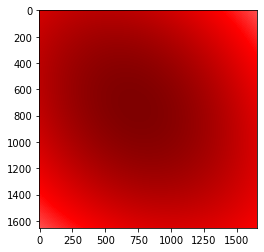

In [38]:
plt.imshow(np.real(analytical_eLOeLO), vmin = -vb, vmax = vb, cmap = 'seismic')

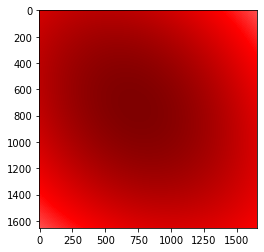

In [40]:
plt.imshow((eLOeLO), vmin = -vb, vmax = vb, cmap = 'seismic')

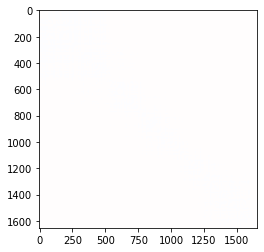

In [43]:
plt.imshow((np.real(analytical_eLOeLO) - eLOeLO)/eLOeLO, vmin = -0.00001, vmax = 0.00001, cmap = 'seismic')

In [47]:
np.allclose(np.real(analytical_eLOeLO), eLOeLO, atol = 0.0, rtol = 1e-8)

True